In [61]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [35]:
# Set-up DataFrame for NLP
subreddits = pd.read_csv('../data/subreddits_clean.csv')

#### Run ONLY when all bugs are fixed

In [100]:
#Set-up X- and y-variables
# NOTE: cvec needs a vector(Series), not a matrix(DataFrame)
X = subreddits['submission_text']
y = subreddits['subreddit']

In [73]:
# Pipeline Set-Up: 
forest_pipe = Pipeline([('cvec', CountVectorizer(stop_words = 'english')), # Stage 1. Count Vectorizer (Transformer)
                        ('rf',   RandomForestClassifier(random_state=86))  # Stage 2. Random Forest (Estimator)
                       ])

# Hyperparameter Search:
forest_pipe_params = {'rf__n_estimators':[75, 100, 125], 'rf__max_depth': (4, 5, 6),
                     'cvec__ngram_range': [(1,2), (2,3)]} # Check (individual tokens) and also check (individual tokens and 2-grams)

# Instantiate GridSearchCV object
forest_gs = GridSearchCV(forest_pipe, # estimator in pipeline object
                  forest_pipe_params,
                  cv = 5, # Five-fold cross validation
                  n_jobs = -2, # 
                  verbose = 2 #
                 )

# Fit the GridSearchCV object to the data.
forest_gs.fit(X_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:  2.3min finished


In [75]:
# Save validation score
forest_train_score = forest_gs.score(X_train, y_train)

# Save validation score
forest_validation_score = forest_gs.score(X_test, y_test)

# Display scores for quick and easy comparison
print('Training Score:   {}\nValidation Score: {}'.format(forest_train_score, forest_validation_score))

Training Score:   0.687
Validation Score: 0.6388


## RUN FIRST!

In [77]:
# To streamline process of stop word identification a random subset of the data, more manageable in size, is introduced here
a = list(np.sort(np.random.choice(list(subreddits.index), size=20000)))
subreddits_a = subreddits.loc[a,['submission_text','subreddit']]

X = subreddits_a['submission_text']
y = subreddits_a['subreddit']

In [78]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y, # ALthough data is very well split b/w y-categories, ensure test/train evenly split
                                                    random_state=86)

In [79]:
# Consider four classifiers to model the subreddit submission text
model_names = [
               'Multinomial NB',
               'LogReg',
               'SVM'
              ]

# Prepare SciKestimators for instantiation
model_classifiers = [
                     MultinomialNB(),
                     LogisticRegression(max_iter=200,random_state=86),
                     SVC(random_state=86)
                    ]


# Choosing only limited No. of hyperparameters to GridSearch over to identify top estimator
# NOTICE: All estimators chosen with 1,2 n-grams
model_params = [ 
                {'est__alpha': [0.01]}, # Multinomial Naive Bayes params: smoothing parameter 0 < alpha < one, 0.01 was best
                # Logistic Regression params: lambda is 1/C
                {'est__C': (np.logspace(-5, 1, 5))},
                # Support Vector Machine Params: Lambda is 1/C
                 {'est__C': (np.logspace(-5, 1, 5))}
                ]

# This clever way of looping though a pipline to GridSearch estimators taken from @montxe on StackOverflow, so cool!
# https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search
for name, estimator, params in zip(model_names, model_classifiers, model_params):
    # Instantiate the pipline: Stage 1: instantiate transformer Stage 2. instantiate all 4 classification estimators
    est_pipe = Pipeline([('cvec', CountVectorizer(max_features = 1000, stop_words='english', ngram_range=(1,2))),
                         #('ss', StandardScaler(with_mean=False)),
                         ('est', estimator)
                        ])

    # Instantiate GridsearchCV Object
    gs_est = GridSearchCV(est_pipe, param_grid=params, n_jobs=-1, verbose=2)
    
    # Fit GridSearchCV Object to training data
    est = gs_est.fit(X_train, y_train)
    
    # Save validation score
    train_score = est.score(X_train, y_train)
    
    # Save validation score
    validation_score = est.score(X_test, y_test)
    
    # Display scores for quick and easy comparison
    print('{}\n\tTraining Score:   {}\n\tValidation Score: {}'.format(name, train_score, validation_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.1s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Multinomial NB
	Training Score:   0.7254666666666667
	Validation Score: 0.706
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   14.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   18.6s finished


LogReg
	Training Score:   0.7467333333333334
	Validation Score: 0.7206
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:  3.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.5min finished


SVM
	Training Score:   0.8794666666666666
	Validation Score: 0.7082


In [108]:
# Pipeline Set-Up: 
logreg_pipe = Pipeline([('cvec', CountVectorizer(max_features=8000, ngram_range=(1,2),stop_words = 'english')), # Stage 1. Count Vectorizer (Transformer)
                        ('logreg',   LogisticRegression(C=10, n_jobs=-2, random_state=86))  # Stage 2. Logistic Regression (Estimator)
                       ])

# Hyperparameter Search:
logreg_pipe_params = {'logreg__C': (np.logspace(-5, 1, 5))}

# Instantiate GridSearchCV object
logreg_gs = GridSearchCV(logreg_pipe, # estimator in pipeline object
                  logreg_pipe_params,
                  cv = 5, # Five-fold cross validation
                  n_jobs = -2, # 
                  verbose = 2 #
                 )

# Fit the GridSearchCV object to the data.
logreg_gs.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  25 | elapsed:   16.5s remaining:    7.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:   19.7s finished


In [ ]:
    # Save validation score
    train_score = logreg_gs.score(X_train, y_train)
    
    # Save validation score
    validation_score = logreg_gs.score(X_test, y_test)

In [111]:
# Consider the set of hyperparameters that acheived the best score
print(logreg_gs.best_params_)

#Consider
print(logreg_gs.best_estimator_)
# Consider dictionary 'named_steps' 
logreg_gs.best_estimator_.named_steps

{'logreg__C': 0.01}
Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=8000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg',
                 LogisticRegression(C=0.01, n_jobs=-2, random_state=86))])


{'cvec': CountVectorizer(max_features=8000, ngram_range=(1, 2), stop_words='english'),
 'logreg': LogisticRegression(C=0.01, n_jobs=-2, random_state=86)}

In [94]:
# Score model on training set.
# from documentation: Mean cross-validated score of the best_estimator
gs_est.best_score_

0.7120666666666666

In [113]:
# Training scores
logreg_train_score = logreg_gs.score(X_train, y_train)

# Test scores
logreg_test_score = logreg_gs.score(X_test, y_test)

print(f'Training Score:\n\tCount-V  = {round(logreg_train_score*100,3)}%')
print(f'Test Score:\n\tCount-V  = {round(logreg_test_score*100,3)}%')

Training Score:
	Count-V  = 78.64%
Test Score:
	Count-V  = 73.26%


In [114]:
logreg_gs.cv_results_

{'mean_fit_time': array([5.62597971, 5.60498433, 5.90355959, 6.2892128 , 4.40600915]),
 'std_fit_time': array([0.06573567, 0.06681907, 0.1224386 , 0.12658392, 1.50129901]),
 'mean_score_time': array([1.01972108, 1.01828403, 1.02342305, 0.94846148, 0.63766384]),
 'std_score_time': array([0.03499063, 0.04658662, 0.0294691 , 0.06634973, 0.2006103 ]),
 'param_logreg__C': masked_array(data=[1e-05, 0.00031622776601683794, 0.01,
                    0.31622776601683794, 10.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logreg__C': 1e-05},
  {'logreg__C': 0.00031622776601683794},
  {'logreg__C': 0.01},
  {'logreg__C': 0.31622776601683794},
  {'logreg__C': 10.0}],
 'split0_test_score': array([0.58166667, 0.706     , 0.722     , 0.70333333, 0.67766667]),
 'split1_test_score': array([0.576     , 0.69433333, 0.71533333, 0.696     , 0.688     ]),
 'split2_test_score': array([0.57766667, 0.701     , 0.726     , 0.69833333,

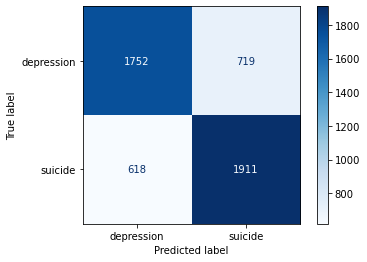

In [121]:
# Get predictions
logreg_preds = logreg_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel()

# View confusion matrix
plot_confusion_matrix(logreg_gs, X_test, y_test, cmap='Blues', values_format='d',
                     display_labels=['depression','suicide']);

### Figure 03

***Confusion Matrix***  illustative of the predictive power of the logistic regression in the model selected above.

In [117]:
# Calculate the sensitivity (recall)
print(tp / (tp + fn))

0.7556346381969158


In [118]:
# Calculate the specificity
print(tn / (tn + fp))

0.7090246863617968


In [119]:
# Calculate the precision
print(tp/ (tp+fp))

0.726615969581749


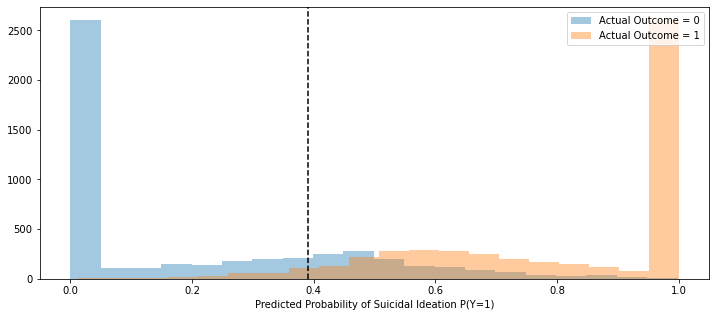

In [153]:
# Visualize the predicted values and the actual values
# 1. The true values of our test set
# 2. The predicted probabilities based on our model

logreg_pred_df = pd.DataFrame({'actual_values': y_test,
                        'pred_probs': logreg_gs.predict_proba(X_test)[:,1]})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in logreg_pred_df.groupby('actual_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
# Add cutoff line
plt.axvline(0.39, color = 'black', linestyle = '--')
plt.xlabel('Predicted Probability of Suicidal Ideation P(Y=1)' )
plt.legend();

#### Fig. 04

This is a distribution of probabilities that complements ***Fig. 02*** in Notebook 03 well. We have a long drawn out spread of features that contribute to a competition between False Positives or False Negatives and overlapping.

In [ ]:
def get_preds(predicted_probs, threshold):
    return [0 if prob < threshold else 1 for prob in predicted_probs]
get_preds(logreg_gs.predict_proba(X_test)[:,1], .3);

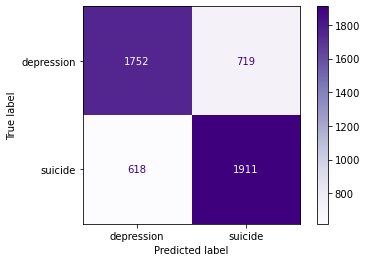

In [151]:
# Get predictions
logreg_preds2 = get_preds(logreg_gs.predict_proba(X_test)[:,1], .39)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds2).ravel()

# View confusion matrix
plot_confusion_matrix(logreg_gs, X_test, y_test, cmap='Purples', values_format='d',
                     display_labels=['depression','suicide']);

In [152]:
# Calculate the sensitivity (recall)
print(tp / (tp + fn))

0.8975879794385132


In [154]:
# Calculate the precision
print(tp/ (tp+fp))

0.6397970687711386


In [93]:
# What other parameters might make an improvement
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}